This lab on Subset Selection is a Python adaptation of p. 244-247 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It is based on the work of R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import statsmodels.datasets as smd
import matplotlib.pyplot as plt

# 6.5.1 Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [2]:
use_smith_edu = False  or True
if use_smith_edu:
    url = ''
    hitters_df = pd.read_csv('https://www.science.smith.edu/~jcrouser/SDS293/data/Hitters.csv')
    hitters_df = hitters_df.set_index('Player')
else:
    hitters_df = smd.get_rdataset('Hitters', 'ISLR')
    hitters_df.data.__doc__ = hitters_df.__doc__
    hitters_df = hitters_df.data
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the `Salary` variable is missing for some of the
players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` value
for any elements that are missing, and a `FALSE` value for non-missing elements.
The `sum()` function can then be used to count all of the missing elements:

In [3]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


We see that `Salary` is missing for 59 players. The `dropna()` function
removes all of the rows that have missing values in any variable:

In [4]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna()

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 20)
Dimensions of modified data: (263, 20)
Number of null values: 0


In [5]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
hitters = hitters_df_clean.drop(['League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
hitters = pd.concat([hitters, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [6]:
itertools.combinations?

Init signature: itertools.combinations(iterable, r)
Docstring:     
Return successive r-length combinations of elements in the iterable.

combinations(range(4), 3) --> (0,1,2), (0,1,3), (0,2,3), (1,2,3)
Type:           type
Subclasses:     


In [7]:
from tqdm.auto import tqdm
def haty_norm2(y, X):
    q, r = np.linalg.qr(X)
    return (np.dot(q.T, y)**2).sum()

def best_k(y, X, k):
    best_v = 0
    best_c = None
    for c in itertools.combinations(range(X.shape[1]),k):
        v = haty_norm2(y, X[:,c])
        if v > best_v:
            best_v = v
            best_c = c
    return best_c, best_v

def best_subset(y, X, max_k=8):
    col_names = X.columns
    y, X = np.asarray(y), np.asarray(X)
    y = y - y.mean(axis=0)
    X = X - X.mean(axis=0)
    q,r = np.linalg.qr(X)
    TSS = (y**2).sum()
    y = np.dot(q.T, y)
    def result(x):
        c,v = x
        return {
            'num_pred': len(c),
            'vars': [col_names[i] for i in c],
            'R2': v/TSS
        }
    return pd.DataFrame([result(best_k(y, r, k+1)) for k in tqdm(range(max_k))]).set_index('num_pred')
    

In [8]:
%%time
fit = pd.DataFrame(best_subset(hitters.Salary, hitters.drop(columns=['Salary']), 19))

  0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 50.5 s, sys: 163 ms, total: 50.7 s
Wall time: 50.8 s


In [9]:
fit

,vars,R2
num_pred,,
1,[CRBI],0.321450
2,"[Hits, CRBI]",0.425224
3,"[Hits, CRBI, PutOuts]",0.451429
4,"[Hits, CRBI, PutOuts, Division_W]",0.475407
5,"[AtBat, Hits, CRBI, PutOuts, Division_W]",0.490804
6,"[AtBat, Hits, Walks, CRBI, PutOuts, Division_W]",0.508715
7,"[Hits, Walks, CAtBat, CHits, CHmRun, PutOuts, ...",0.514123
8,"[AtBat, Hits, Walks, CHmRun, CRuns, CWalks, Pu...",0.528557
9,"[AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",0.534612


In [10]:
fit['model'] = [sm.OLS.from_formula(f, data=hitters).fit()
              for f in fit.vars.apply(lambda x: 'Salary ~ ' + ' + '.join(sorted(x)))]

In [11]:
def traverse_tree(y, X, best_v, best_subset, k=0, v_offset=0):
    idx = np.arange(X.shape[1])
    for i in range(X.shape[1]):
        x, X0 = X[:,i], X[:,idx!=i]
        traverse_tree(y, X0, best_v, best_subset, k=k, v_offset=v_offset)
        x = x/np.linalg.norm(x) 
        X0 = X0 - np.dot(x,X0)
        c = np.dot(x, y)
        y0 = y - c*x
        traverse_tree(y0, X0, best_v, best_subset, k=k+1, v_offset=v_offset+c**2)
        
def bestsubset(y, X):
    y, X = np.asarray(y), np.asarray(X)
    y = y - y.mean(axis=0)
    X = X - X.mean(axis=0)
    q, r = np.linalg.qr(X)
    TSS = (y**2).sum()
    y, X = np.dot(q.T, y), r
    p, = y.shape
    best_v = np.zeros(p)
    best_subset = [None]*p
    traverse_tree()
    return best_v/TSS, best_subset

In [12]:
# def processSubset(feature_set):
#     # Fit model on feature_set and calculate RSS
#     model = sm.OLS(y,X[list(feature_set)])
#     regr = model.fit()
#     RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
#     return {"model":regr, "RSS":RSS}

In [13]:
# def getBest(k):
    
#     tic = time.time()
    
#     results = []
    
#     for combo in itertools.combinations(X.columns, k):
#         results.append(processSubset(combo))
    
#     # Wrap everything up in a nice dataframe
#     models = pd.DataFrame(results)
    
#     # Choose the model with the highest RSS
#     best_model = models.loc[models['RSS'].argmin()]
    
#     toc = time.time()
#     print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
#     # Return the best model, along with some other useful information about the model
#     return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [14]:
# # Could take quite a while to complete...

# models_best = pd.DataFrame(columns=["RSS", "model"])

# tic = time.time()
# for i in range(1,4):
#     models_best.loc[i] = getBest(i)

# toc = time.time()
# print("Total elapsed time:", (toc-tic), "seconds.")

Now we have one big `DataFrame` that contains the best models we've generated along with their RSS:

In [15]:
# models_best['model'][2].summary()

If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [16]:
print(fit.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     96.17
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           5.43e-32
Time:                        17:43:26   Log-Likelihood:                -1907.2
No. Observations:                 263   AIC:                             3820.
Df Residuals:                     260   BIC:                             3831.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -47.9559     55.982     -0.857      0.3

This output indicates that the best two-variable model
contains only `Hits` and `CRBI`. To save time, we only generated results
up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [17]:
# Show the best 19-variable model (there's actually only one)
print(fit.model.iloc()[-1].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     15.39
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           7.84e-32
Time:                        17:43:26   Log-Likelihood:                -1876.2
No. Observations:                 263   AIC:                             3792.
Df Residuals:                     243   BIC:                             3864.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     163.1036     90.779      1.797      

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [18]:
fit.loc[2, "model"].rsquared

0.42522374646677874

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [19]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
print('R2:', fit.model.apply(lambda x: x.rsquared), sep='\n')
print('RSS:', fit.model.apply(lambda x: x.ssr), sep='\n')

R2:
num_pred
1     0.321450
2     0.425224
3     0.451429
4     0.475407
5     0.490804
6     0.508715
7     0.514123
8     0.528557
9     0.534612
10    0.540495
11    0.542615
12    0.543630
13    0.544457
14    0.545216
15    0.545469
16    0.545766
17    0.545952
18    0.546095
19    0.546116
Name: model, dtype: float64
RSS:
num_pred
1     3.617968e+07
2     3.064656e+07
3     2.924930e+07
4     2.797085e+07
5     2.714990e+07
6     2.619490e+07
7     2.590655e+07
8     2.513693e+07
9     2.481405e+07
10    2.450040e+07
11    2.438735e+07
12    2.433323e+07
13    2.428915e+07
14    2.424866e+07
15    2.423518e+07
16    2.421938e+07
17    2.420945e+07
18    2.420184e+07
19    2.420070e+07
Name: model, dtype: float64


As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select.

In [20]:
# plt.rcParams

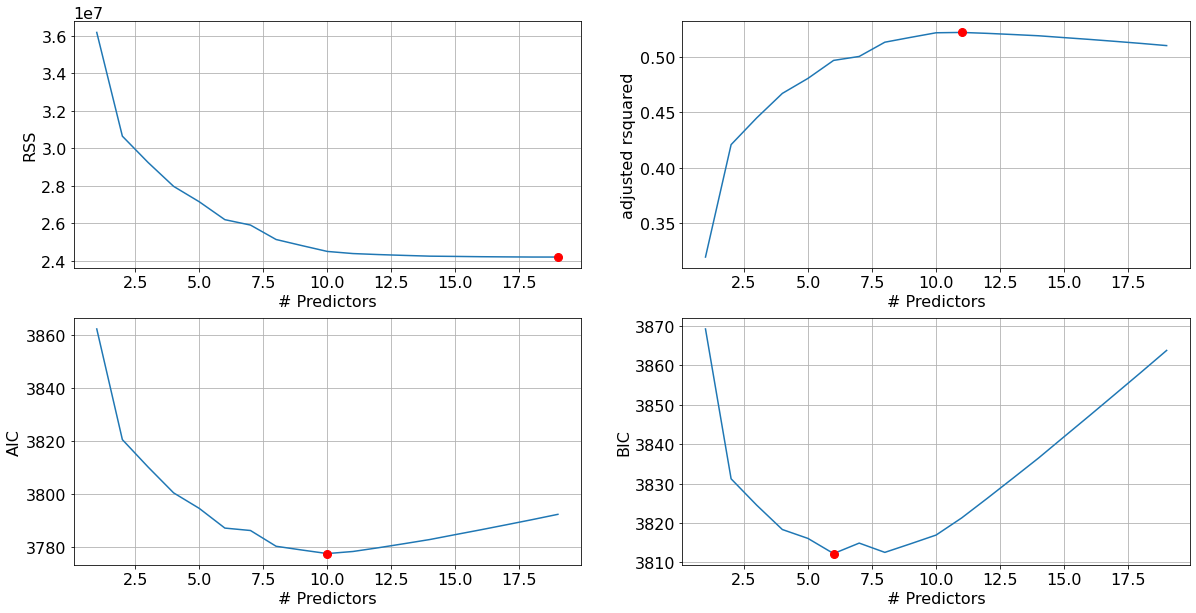

In [21]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 16, 'lines.markersize': 8})

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt_data = np.stack(fit.apply(lambda x: (len(x['vars']), x['model'].ssr), axis=1))

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)
plt.plot(*plt_data.T)
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.grid()
plt.plot(*plt_data[plt_data[:,1].argmin()], 'or')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

plt_data = np.stack(fit.apply(lambda x: (len(x['vars']), x['model'].rsquared_adj), axis=1))

plt.subplot(2, 2, 2)
plt.plot(*plt_data.T)
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
plt.grid()
plt.plot(*plt_data[plt_data[:,1].argmax()], 'or')


# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
plt_data = np.stack(fit.apply(lambda x: (len(x['vars']), x['model'].aic), axis=1))

plt.subplot(2, 2, 3)
plt.plot(*plt_data.T)
plt.xlabel('# Predictors')
plt.ylabel('AIC')
plt.grid()
plt.plot(*plt_data[plt_data[:,1].argmin()], 'or')


plt_data = np.stack(fit.apply(lambda x: (len(x['vars']), x['model'].bic), axis=1))

plt.subplot(2, 2, 4)
plt.plot(*plt_data.T)
plt.xlabel('# Predictors')
plt.ylabel('BIC')
plt.grid()
plt.plot(*plt_data[plt_data[:,1].argmin()], 'or')


Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

# 6.5.2 Forward and Backward Stepwise Selection
We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

In [22]:
def forward(y, X):
    col_names = list(X.columns)
    y, X = np.asarray(y), np.asarray(X)
    y = y - y.mean(axis=0)
    X = X - X.mean(axis=0)
    q, X = np.linalg.qr(X)
    TSS = (y**2).sum()
    y = np.dot(q.T, y)
    tv = 0
    result = []
    predictors = []
    while len(col_names)>0:
        (c,), v = best_k(y, X, 1)
        tv += v
        predictors.append(col_names.pop(c))
        result.append(dict(num_pred=len(predictors), predictors=predictors.copy(), r2=tv/TSS))
        x, X = X[:,c], X[:,np.arange(X.shape[1])!=c] 
        x = x/np.linalg.norm(x)
        y = y - np.dot(y,x)*x
        X = X - np.outer(x, np.dot(x.T, X))
    return pd.DataFrame(result).set_index('num_pred')


Now let's see how much faster it runs!

In [23]:
fwd_fit = forward(hitters.Salary, hitters.drop(columns=['Salary']))
fwd_fit

,predictors,r2
num_pred,,
1,[CRBI],0.321450
2,"[CRBI, Hits]",0.425224
3,"[CRBI, Hits, PutOuts]",0.451429
4,"[CRBI, Hits, PutOuts, Division_W]",0.475407
5,"[CRBI, Hits, PutOuts, Division_W, AtBat]",0.490804
6,"[CRBI, Hits, PutOuts, Division_W, AtBat, Walks]",0.508715
7,"[CRBI, Hits, PutOuts, Division_W, AtBat, Walks...",0.513229
8,"[CRBI, Hits, PutOuts, Division_W, AtBat, Walks...",0.528139
9,"[CRBI, Hits, PutOuts, Division_W, AtBat, Walks...",0.534612


In [24]:
def regress_on(v):
    return sm.OLS.from_formula('Salary ~ ' + ' + '.join(sorted(v)), data=hitters).fit()

fwd_fit['model'] = [regress_on(v) for v in fwd_fit.predictors]

Phew! That's a lot better. Let's take a look:

In [25]:
fwd_fit.apply(lambda x: (x['model'].rsquared, x['r2']), axis=1)

num_pred
1     (0.3214500886678946, 0.32145008866789465)
2     (0.42522374646677874, 0.4252237464667787)
3     (0.45142941571795725, 0.4514294157179571)
4     (0.47540665339478694, 0.4754066533947868)
5      (0.4908036159635182, 0.4908036159635181)
6      (0.5087145573589968, 0.5087145573589966)
7      (0.5132286393324803, 0.5132286393324802)
8      (0.5281385504329166, 0.5281385504329165)
9      (0.5346124477924314, 0.5346124477924314)
10     (0.5404949509407984, 0.5404949509407982)
11     (0.5426153254254202, 0.5426153254254202)
12      (0.543630208632163, 0.5436302086321629)
13     (0.5444570142319775, 0.5444570142319773)
14      (0.5452163563014891, 0.545216356301489)
15     (0.5454692306811637, 0.5454692306811637)
16     (0.5457655574852799, 0.5457655574852798)
17      (0.545951808076699, 0.5459518080766989)
18      (0.5460945223419063, 0.546094522341906)
19     (0.5461158619125321, 0.5461158619125321)
dtype: object

In [26]:
print(fwd_fit.loc[1, "model"].summary())
print(fwd_fit.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     123.6
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           9.07e-24
Time:                        17:43:27   Log-Likelihood:                -1929.1
No. Observations:                 263   AIC:                             3862.
Df Residuals:                     261   BIC:                             3869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    274.5804     32.855      8.357      0.0

We see that using forward stepwise selection, the best one-variable
model contains only `Hits`, and the best two-variable model additionally
includes `CRBI`. Let's see how the models stack up against best subset selection:

In [27]:
print(fit.loc[7, "model"].params)
print(fwd_fit.loc[7, "model"].params)

Intercept      79.450947
CAtBat         -0.375235
CHits           1.495707
CHmRun          1.442054
Division_W   -129.986643
Hits            1.283351
PutOuts         0.236681
Walks           3.227426
dtype: float64
Intercept     109.787306
AtBat          -1.958885
CRBI            0.853762
CWalks         -0.305307
Division_W   -127.122393
Hits            7.449877
PutOuts         0.253340
Walks           4.913140
dtype: float64


For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.

# Backward Selection
Not much has to change to implement backward selection... just looping through the predictors in reverse!

In [28]:
def backward(y, X):
    col_names = list(X.columns)
    y, X = np.asarray(y), np.asarray(X)
    y = y - y.mean(axis=0)
    X = X - X.mean(axis=0)
    q, X = np.linalg.qr(X)
    TSS = (y**2).sum()
    y = np.dot(q.T, y)
    tv = 0
    result = []
    while len(col_names)>1:
        c, v = best_k(y, X, len(col_names)-1)
        col_names = [col_names[i] for i in c]
        result.append(dict(num_pred=len(c), 
                           predictors=col_names, 
                           r2=v/TSS))
        X = X[:,c] 
    return pd.DataFrame(result).set_index('num_pred')


In [29]:
bwd_fit = backward(hitters.Salary, hitters.drop(columns=['Salary']))
print(bwd_fit)
bwd_fit['model'] = [regress_on(v) for v in bwd_fit.predictors]

                                                 predictors        r2
num_pred                                                             
18        [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...  0.546095
17        [AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...  0.545952
16        [AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...  0.545766
15        [AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit...  0.545469
14        [AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRun...  0.545216
13        [AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...  0.544457
12        [AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...  0.543630
11        [AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...  0.542615
10        [AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...  0.540495
9         [AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...  0.534612
8         [AtBat, Hits, Walks, CRuns, CRBI, CWalks, PutO...  0.528139
7         [AtBat, Hits, Walks, CRuns, CWalks, PutOuts, D...  0.513617
6          [AtBat, H

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection,
backward stepwise selection, and best subset selection are different:

In [30]:
print("------------")
print("Best Subset:")
print("------------")
print(fit.loc[7, "model"].params)

------------
Best Subset:
------------
Intercept      79.450947
CAtBat         -0.375235
CHits           1.495707
CHmRun          1.442054
Division_W   -129.986643
Hits            1.283351
PutOuts         0.236681
Walks           3.227426
dtype: float64


In [31]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(fwd_fit.loc[7, "model"].params)

-----------------
Foward Selection:
-----------------
Intercept     109.787306
AtBat          -1.958885
CRBI            0.853762
CWalks         -0.305307
Division_W   -127.122393
Hits            7.449877
PutOuts         0.253340
Walks           4.913140
dtype: float64


In [32]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(bwd_fit.loc[7, "model"].params)

-------------------
Backward Selection:
-------------------
Intercept     105.648749
AtBat          -1.976284
CRuns           1.129309
CWalks         -0.716335
Division_W   -116.169217
Hits            6.757491
PutOuts         0.302885
Walks           6.055869
dtype: float64
